# CNN Cancer Detection - Submission to Histopathologic Cancer Detection Kaggle Competition

The problem: In this competition, we are tasked to create an algorithm that will identify metastatic cancer from small images patches with as high accuracy as possible.

The data: We are provided with a large number of small pathology images. The test file has 57.5k files named with an image id, and the train_labels folder provides ground truth labeling for the train files.

# Environment Set Up, and create dataframes

After importing some key libraries, we are setting up a distribution strategy. A TPU has eight different cores (sort of like having eight GPUs in one machine). We can tell TensorFlow how to best use these cores all at once.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import Adam

2024-06-04 12:38:59.588132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:38:59.588268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:38:59.729918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
train.id = train.id + '.tif'
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [3]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

(176020, 2)
(44005, 2)


# Exploratory Data Analysis

In [4]:
# Out of curosity, checking the proportion of 0 to 1 data labels in the ground truth data set.

(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


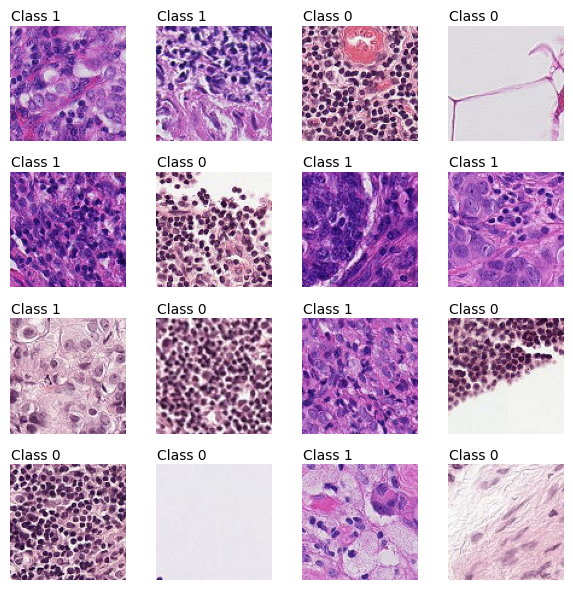

In [5]:
# Taking a look at what the data actually looks like, print some of the images with their ground truth labels.

train_path = "../input/histopathologic-cancer-detection/train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{row.id}')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

# Analysis - Model Building and Training

In [6]:
# Preprocessing the images using ImageDataGenerator

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [7]:
# Creating Data Generators for CNN

img_dir = '/kaggle/input/histopathologic-cancer-detection/train'

train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary'
)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=img_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Build a base model
model = Sequential()

# Convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))

# Second layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))
    
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
TR_STEPS = 11001
VA_STEPS = 2750

h1 = model.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 10,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS,
    verbose = 1
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11001/11001 ━━━━━━━━━━━━━━━━━━━━ 2872s 261ms/step - accuracy: 0.7592 - loss: 0.5093 - val_accuracy: 0.8077 - val_loss: 0.4220
Epoch 2/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.8750 - loss: 0.2561 - val_accuracy: 0.8000 - val_loss: 0.3888
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11001/11001 ━━━━━━━━━━━━━━━━━━━━ 2031s 185ms/step - accuracy: 0.8252 - loss: 0.3985 - val_accuracy: 0.8148 - val_loss: 0.4271
Epoch 4/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6875 - loss: 0.5880 - val_accuracy: 0.8000 - val_loss: 0.3176
Epoch 5/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 1942s 176ms/step - accuracy: 0.8415 - loss: 0.3681 - val_accuracy: 0.8271 - val_loss: 0.3952
Epoch 6/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8125 - loss: 0.4632 - val_accuracy: 1.0000 - val_loss: 0.1895
Epoch 7/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 1994s 181ms/step - accuracy: 0.8466 - loss: 0.3570 - val_accuracy: 0.8101 - val_loss: 0.4275
Epoch 8/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8125 - loss: 0.3783 - val_accuracy: 0.6000 - val_loss: 0.4894
Epoch 9/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 1971s 179ms/step - accuracy: 0.8512 - loss: 0.3465 - val_accuracy: 0.8253 - val_loss: 0.4082
Epoch 10/10
11001/11001 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accura

In [14]:
# Helper functions for visualizing the accuracy, loss and AUC per epoch
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show

# Results

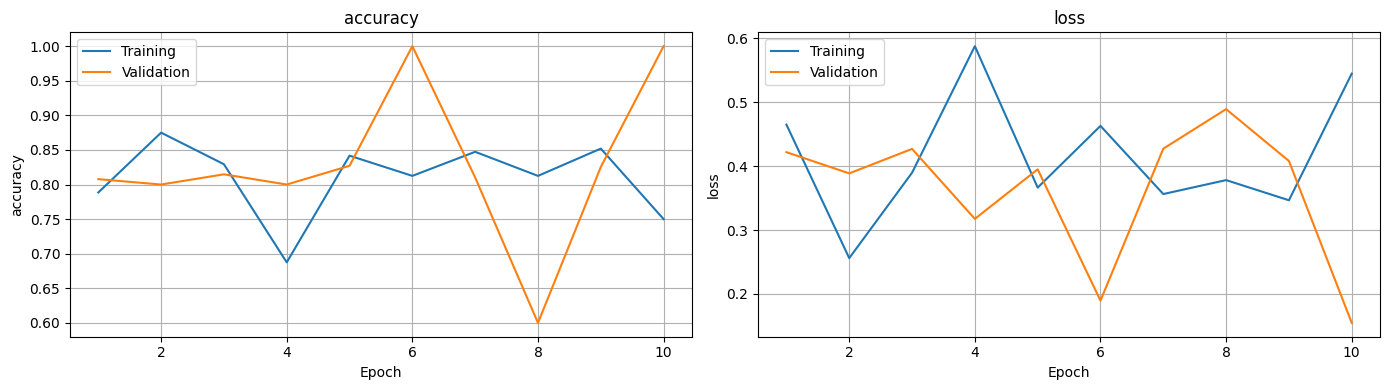

In [15]:
# Print plots to show our training model results

history = merge_history([h1])
vis_training(history)

**The results from this model don't seem to converge, which makes me wonder if the learning rate is too high and is missing the target on some epochs.**

# Discussion and conclusion

Hyperparameter tuning should be used on this model to create convergence and minimize loss.

# Prepare Competition Submission

In [16]:
test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test['filename'] = test.id + '.tif'
test_path = "../input/histopathologic-cancer-detection/test"

In [17]:
BATCH_SIZE = 16

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


In [18]:
test_probs = model.predict(test_loader)

   1/3592 ━━━━━━━━━━━━━━━━━━━━ 12:36 211ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 502s 140ms/step


In [20]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = test_probs[:,0]
submission.to_csv('submission.csv', header=True, index=False)


**Appendix - Useful Links and Sources**
Taylor Kern & Naveen Kumar Ravella's code for this competition: https://www.kaggle.com/code/naveenkumarravella/histopathologic-cancer-detection